## Import 

In [333]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') # Suppress warnings

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Dataset 1_route_quarter - Exploration and Cleaning
#### Explore route_quarter dataset
#### Dataset describes travel to and from Ireland by routes between the years of 1985 and 2008, Quarterly, by Route of Travel.

In [334]:
# Read csv file into pandas dataframe 
# url = https://data.gov.ie/dataset/tmq01-visits-to-and-from-ireland/resource/d018a88d-6944-4728-aa62-cd05074ffa5e
# route_quarter_TMQ01-Visits-to-and-from-Ireland dataset contains 8 columns and 960 rows 
# (24 years in Quarters = 96 rows), 96 rows by 2 Direction = 192 rows, 192 rows by 5 regions = 960 rows
# Columns: ROUTE, Route of Travel, TLIST(Q1), Quarter,STATISTIC, Statistic Label, UNIT, VALUE
route_quarter = pd.read_csv("TMQ01-Visits-to-and-from-Ireland.csv")
route_quarter.shape
print(route_quarter.columns)
route_quarter.head()

(960, 8)

Index(['ROUTE', 'Route of Travel', 'TLIST(Q1)', 'Quarter', 'STATISTIC',
       'Statistic Label', 'UNIT', 'VALUE'],
      dtype='object')


,ROUTE,Route of Travel,TLIST(Q1),Quarter,STATISTIC,Statistic Label,UNIT,VALUE
0,0,All Routes,19851,1985Q1,TMQ01C1,Visitors to Ireland,Thousand,254
1,0,All Routes,19851,1985Q1,TMQ01C2,Visits Abroad by Irish Residents,Thousand,186
2,0,All Routes,19852,1985Q2,TMQ01C1,Visitors to Ireland,Thousand,495
3,0,All Routes,19852,1985Q2,TMQ01C2,Visits Abroad by Irish Residents,Thousand,336
4,0,All Routes,19853,1985Q3,TMQ01C1,Visitors to Ireland,Thousand,840


## Display value counts for each column in the dataframe

In [335]:
route_quarter['ROUTE'].value_counts()
route_quarter['Route of Travel'].value_counts()
route_quarter['TLIST(Q1)'].value_counts()
route_quarter['Quarter'].value_counts()
route_quarter['STATISTIC'].value_counts()
route_quarter['Statistic Label'].value_counts()
route_quarter['UNIT'].value_counts()
route_quarter['VALUE'].value_counts(bins=5)

ROUTE
0    192
1    192
2    192
3    192
4    192
Name: count, dtype: int64

Route of Travel
All Routes            192
Air Cross Channel     192
Sea Cross Channel     192
Continental Europe    192
Transatlantic         192
Name: count, dtype: int64

TLIST(Q1)
19851    10
19852    10
20023    10
20022    10
20021    10
         ..
19922    10
19921    10
19914    10
19913    10
20084    10
Name: count, Length: 96, dtype: int64

Quarter
1985Q1    10
1985Q2    10
2002Q3    10
2002Q2    10
2002Q1    10
          ..
1992Q2    10
1992Q1    10
1991Q4    10
1991Q3    10
2008Q4    10
Name: count, Length: 96, dtype: int64

STATISTIC
TMQ01C1    480
TMQ01C2    480
Name: count, dtype: int64

Statistic Label
Visitors to Ireland                 480
Visits Abroad by Irish Residents    480
Name: count, dtype: int64

UNIT
Thousand    960
Name: count, dtype: int64

(2.359, 533.0]      711
(533.0, 1061.0]     158
(1061.0, 1589.0]     51
(1589.0, 2117.0]     26
(2117.0, 2645.0]     14
Name: count, dtype: int64

## Edit Dataframe 1 - Data Cleaning 
### Remove, Rename and Transform columns

In [336]:
# Remove 'UNIT' column as 'VALUE' column heading will be amended to reflect units. 
# Remove 'ROUTE' column as 'Route of Travel' contains the same information in human readable language.
# Remove 'STATISTIC' column as this data is contained within 'Quarter' and 'Statistic Label' columns in human readable language.
route_quarter_tourism = route_quarter.drop(columns=['UNIT', 'ROUTE', 'STATISTIC'])

# Rename 'TLIST(Q1)' column to Year
route_quarter_tourism.rename(columns={"TLIST(Q1)": "Year"}, inplace=True)

# Last character in 'Year' column refers to quarter (1-4) 
# Remove last character from by dividing by 10 and saving as integer to remove non-whole numbers. e.g. 19854 -> 1985.4 = 1985
route_quarter_tourism["Year"] = route_quarter_tourism["Year"].transform(lambda x: x / 10).astype(int)

# The'Quarter' column contains the year and Q before the number designating the quarter. e.g. 1985Q4
# Transform 'Quarter' column, reassigning last character of each entry as integer reflecting the quarter. e.g. 1985Q4 = 4
route_quarter_tourism["Quarter"] = route_quarter_tourism["Quarter"].transform(lambda x: str(x)[-1]).astype(int)

# Rename 'Statistic Label' column for Direction
route_quarter_tourism.rename(columns={"Statistic Label": "Direction"}, inplace=True)

# Rename Column for Travellers x 1,000
route_quarter_tourism.rename(columns={"VALUE": "Travellers x(1,000)"}, inplace=True)

route_quarter_tourism.shape

(960, 5)

### Explore edited route_quarter dataset

In [337]:
route_quarter_tourism.shape
print(route_quarter_tourism.columns)
route_quarter_tourism.head()


(960, 5)

Index(['Route of Travel', 'Year', 'Quarter', 'Direction',
       'Travellers x(1,000)'],
      dtype='object')


,Route of Travel,Year,Quarter,Direction,"Travellers x(1,000)"
0,All Routes,1985,1,Visitors to Ireland,254
1,All Routes,1985,1,Visits Abroad by Irish Residents,186
2,All Routes,1985,2,Visitors to Ireland,495
3,All Routes,1985,2,Visits Abroad by Irish Residents,336
4,All Routes,1985,3,Visitors to Ireland,840


## Display value counts for each column in the edited dataframe

In [338]:
route_quarter_tourism['Route of Travel'].value_counts()
route_quarter_tourism['Year'].value_counts()
route_quarter_tourism['Quarter'].value_counts()
route_quarter_tourism['Direction'].value_counts()
route_quarter_tourism['Travellers x(1,000)'].value_counts(bins=5)


Route of Travel
All Routes            192
Air Cross Channel     192
Sea Cross Channel     192
Continental Europe    192
Transatlantic         192
Name: count, dtype: int64

Year
1985    40
1986    40
2007    40
2006    40
2005    40
2004    40
2003    40
2002    40
2001    40
2000    40
1999    40
1998    40
1997    40
1996    40
1995    40
1994    40
1993    40
1992    40
1991    40
1990    40
1989    40
1988    40
1987    40
2008    40
Name: count, dtype: int64

Quarter
1    240
2    240
3    240
4    240
Name: count, dtype: int64

Direction
Visitors to Ireland                 480
Visits Abroad by Irish Residents    480
Name: count, dtype: int64

(2.359, 533.0]      711
(533.0, 1061.0]     158
(1061.0, 1589.0]     51
(1589.0, 2117.0]     26
(2117.0, 2645.0]     14
Name: count, dtype: int64

## Assess change in the distribution of Cross Channel between Air and Sea over time.

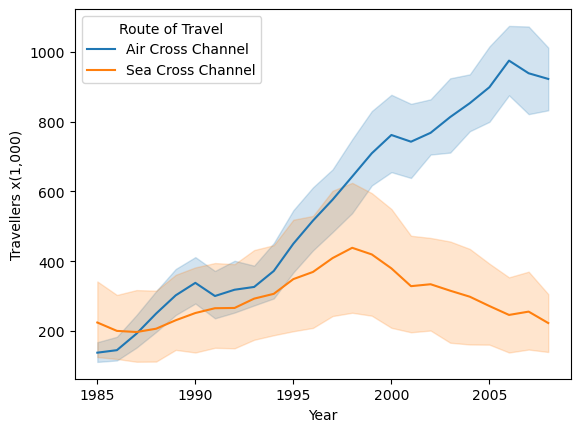

In [339]:
x_channel = route_quarter_tourism.loc[((route_quarter_tourism['Route of Travel'] == 'Air Cross Channel') | (route_quarter_tourism['Route of Travel'] == 'Sea Cross Channel')) & (route_quarter_tourism['Direction'] == 'Visitors to Ireland')]
linplot = sns.lineplot(x="Year", y="Travellers x(1,000)", hue="Route of Travel", data=x_channel)


In [387]:
freqs = calculate_frequencies(x_channel)
freqs['year quarter'] = freqs['Year'].astype(str) + 'Q' + freqs['Quarter'].astype(str)
freqs
freqs.dtypes

(192, 7)
(192,)


,Route of Travel,Year,Quarter,Direction,"Travellers x(1,000)",Distribution Per Route,year quarter
0,Air Cross Channel,1985,1,Visitors to Ireland,110,0.521327,1985Q1
1,Sea Cross Channel,1985,1,Visitors to Ireland,101,0.478673,1985Q1
2,Air Cross Channel,1985,2,Visitors to Ireland,142,0.387978,1985Q2
3,Sea Cross Channel,1985,2,Visitors to Ireland,224,0.612022,1985Q2
4,Air Cross Channel,1985,3,Visitors to Ireland,186,0.305921,1985Q3
...,...,...,...,...,...,...,...
187,Sea Cross Channel,2008,2,Visitors to Ireland,258,0.211823,2008Q2
188,Air Cross Channel,2008,3,Visitors to Ireland,1065,0.751058,2008Q3
189,Sea Cross Channel,2008,3,Visitors to Ireland,353,0.248942,2008Q3
190,Air Cross Channel,2008,4,Visitors to Ireland,843,0.859327,2008Q4


Route of Travel            object
Year                        int32
Quarter                     int32
Direction                  object
Travellers x(1,000)         int64
Distribution Per Route    float64
year quarter               object
dtype: object

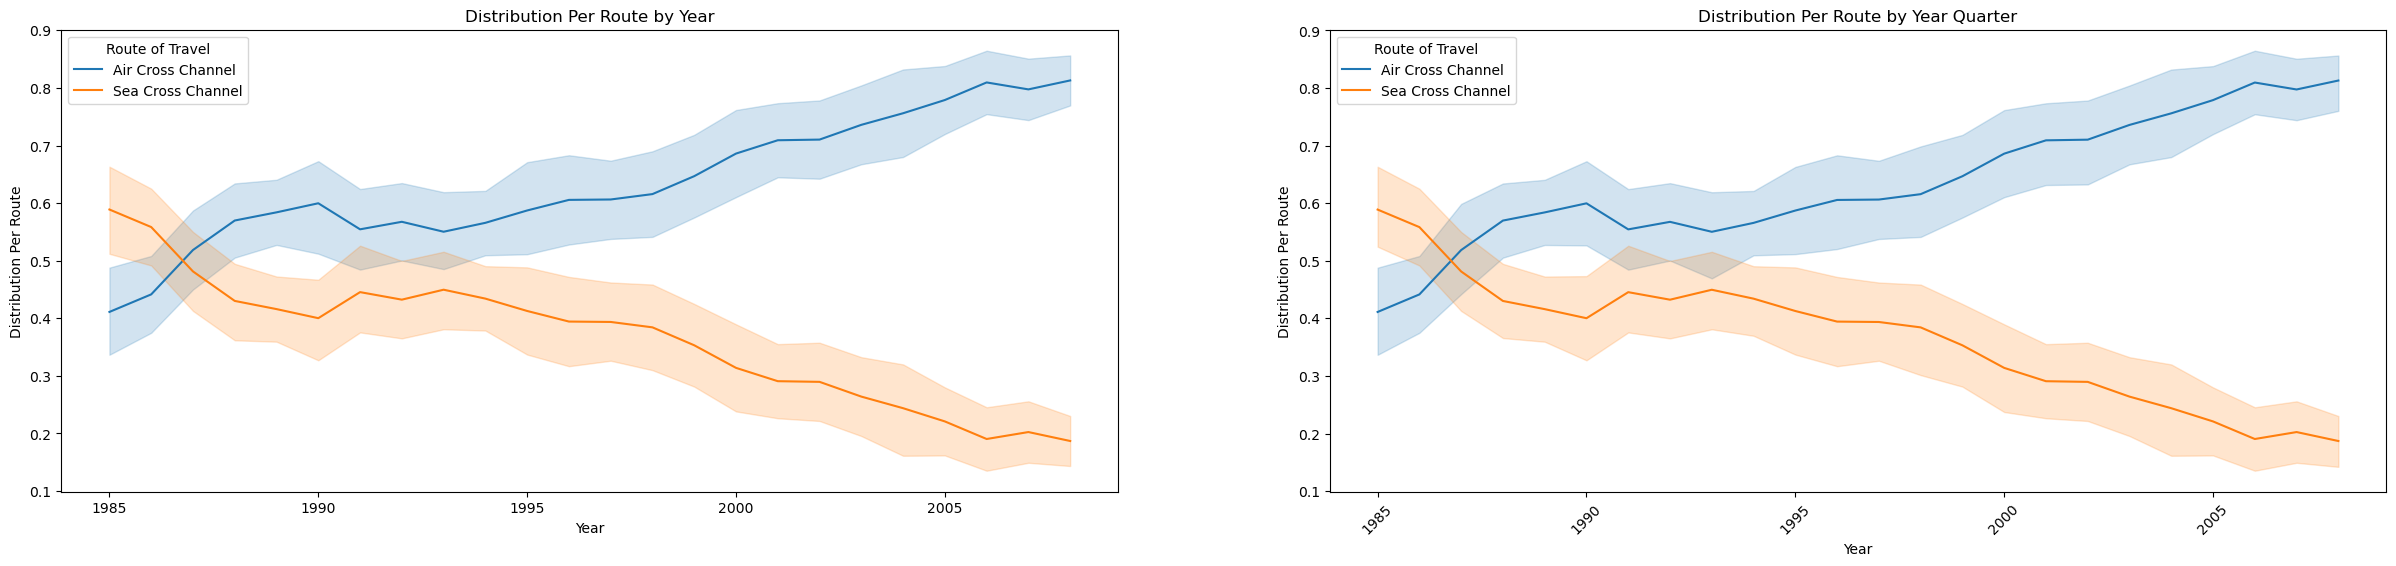

In [376]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(30, 6))
sns.lineplot(x="Year", y="Distribution Per Route", hue="Route of Travel", data=freqs, ax=ax1)
plt.xticks(rotation=45)

sns.lineplot(x="Year", y="Distribution Per Route", hue="Route of Travel", data=freqs, ax=ax2)
plt.xticks(rotation=45)
ax1.set_title('Distribution Per Route by Year')
ax2.set_title('Distribution Per Route by Year Quarter')
plt.show(); # Put semicolon as per https://stackoverflow.com/questions/51030011/maplotlib-gives-the-list-of-array-outputs-before-showing-the-scatter-plot-in-pyt as otherise it will show the array of the output before the graphs

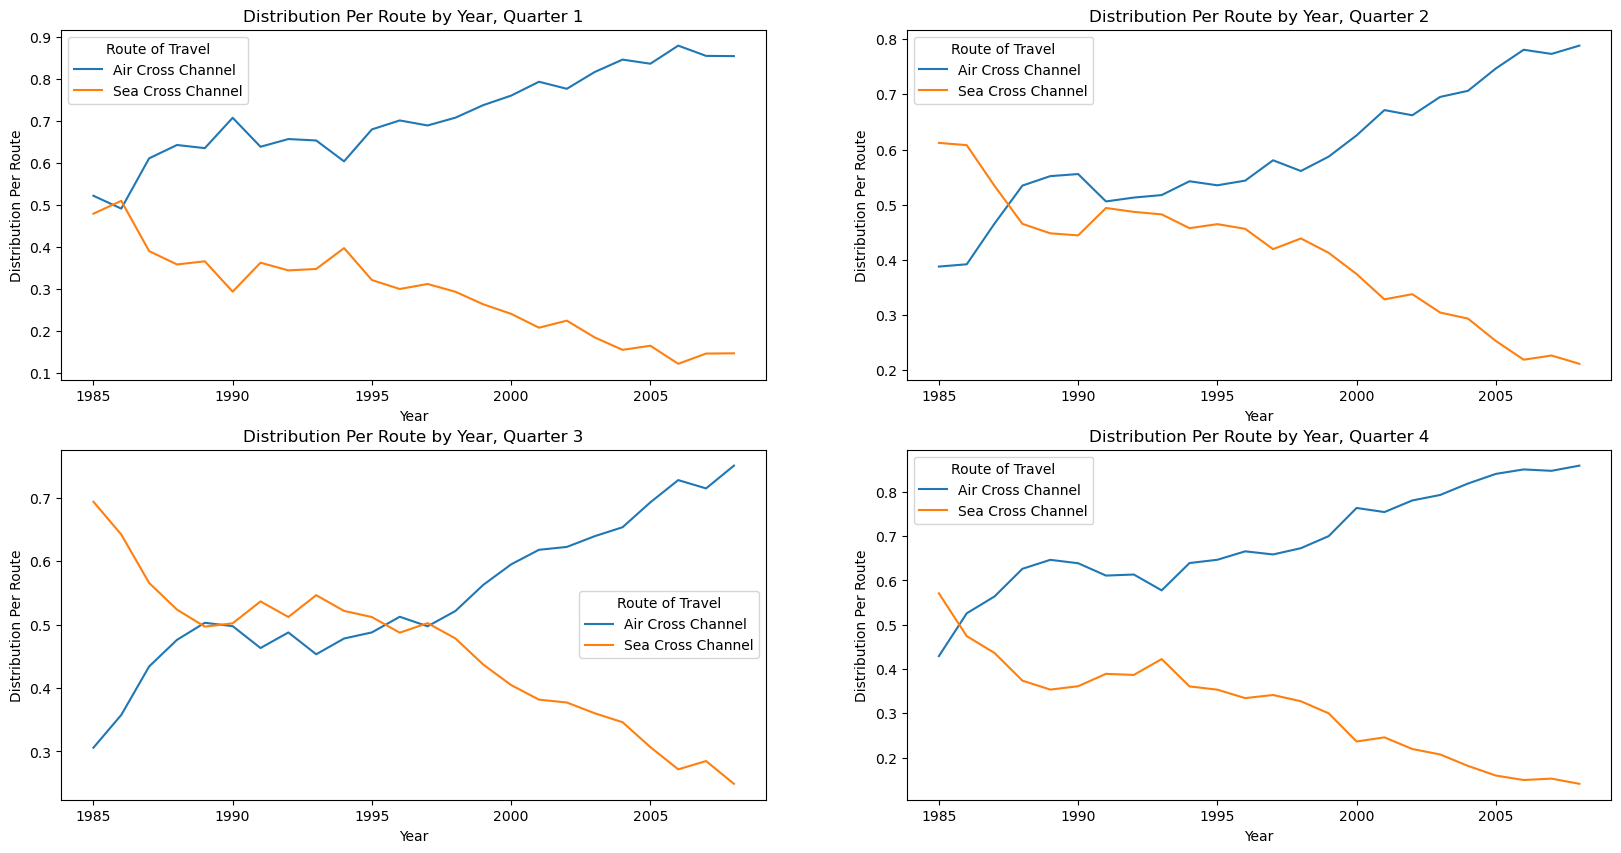

In [402]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

q1 = freqs.loc[(freqs['Quarter'] == 1)]
sns.lineplot(x="Year", y="Distribution Per Route", hue="Route of Travel", data=q1, ax=axes[0, 0])

q2 = freqs.loc[(freqs['Quarter'] == 2)]
sns.lineplot(x="Year", y="Distribution Per Route", hue="Route of Travel", data=q2, ax=axes[0, 1])

q3 = freqs.loc[(freqs['Quarter'] == 3)]
sns.lineplot(x="Year", y="Distribution Per Route", hue="Route of Travel", data=q3, ax=axes[1, 0])

q4 = freqs.loc[(freqs['Quarter'] == 4)]
sns.lineplot(x="Year", y="Distribution Per Route", hue="Route of Travel", data=q4, ax=axes[1, 1])

axes[0, 0].set_title('Distribution Per Route by Year, Quarter 1')
axes[0, 1].set_title('Distribution Per Route by Year, Quarter 2')
axes[1, 0].set_title('Distribution Per Route by Year, Quarter 3')
axes[1, 1].set_title('Distribution Per Route by Year, Quarter 4')

plt.show();


NameError: name 'x' is not defined

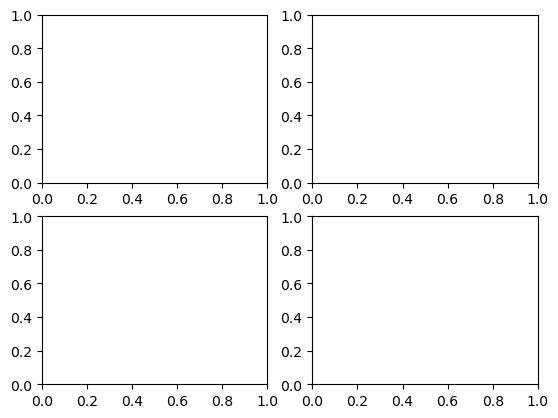

In [384]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(x, y)
axs[0, 0].set_title('Distribution Per Route by Year, Quarter 1 [0, 0]')
axs[0, 1].plot(x, y, 'tab:orange')
axs[0, 1].set_title('Axis [0, 1]')
axs[1, 0].plot(x, -y, 'tab:green')
axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(x, -y, 'tab:red')
axs[1, 1].set_title('Axis [1, 1]')

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

<Axes: xlabel='year quarter', ylabel='Distribution Per Route'>

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]),
 [Text(0, 0, '1985Q1'),
  Text(1, 0, '1985Q2'),
  Text(2, 0, '1985Q3'),
  Text(3, 0, '1985Q4'),
  Text(4, 0, '1986Q1'),
  Text(5, 0, '1986Q2'),
  Text(6, 0, '1986Q3'),
  Text(7, 0, '1986Q4'),
  Text(8, 0, '1987Q1'),
  Text(9, 0, '1987Q2'),
  Text(10, 0, '1987Q3'),
  Text(11, 0, '1987Q4'),
  Text(12, 0, '1988Q1'),
  Text(13, 0, '1988Q2'),
  Text(14, 0, '1988Q3'),
  Text(15, 0, '1988Q4'),
  Text(16, 0, '1989Q1'),
  Text(17, 0, '1989Q2'),
  Text(18, 0, '1989Q3'),
  Text(19, 0, '1989Q4'),
  Text(20, 0, '1990Q1'),
  Text(21, 0, '1990Q2'),
  Text(22, 0, '1990Q3'),
 

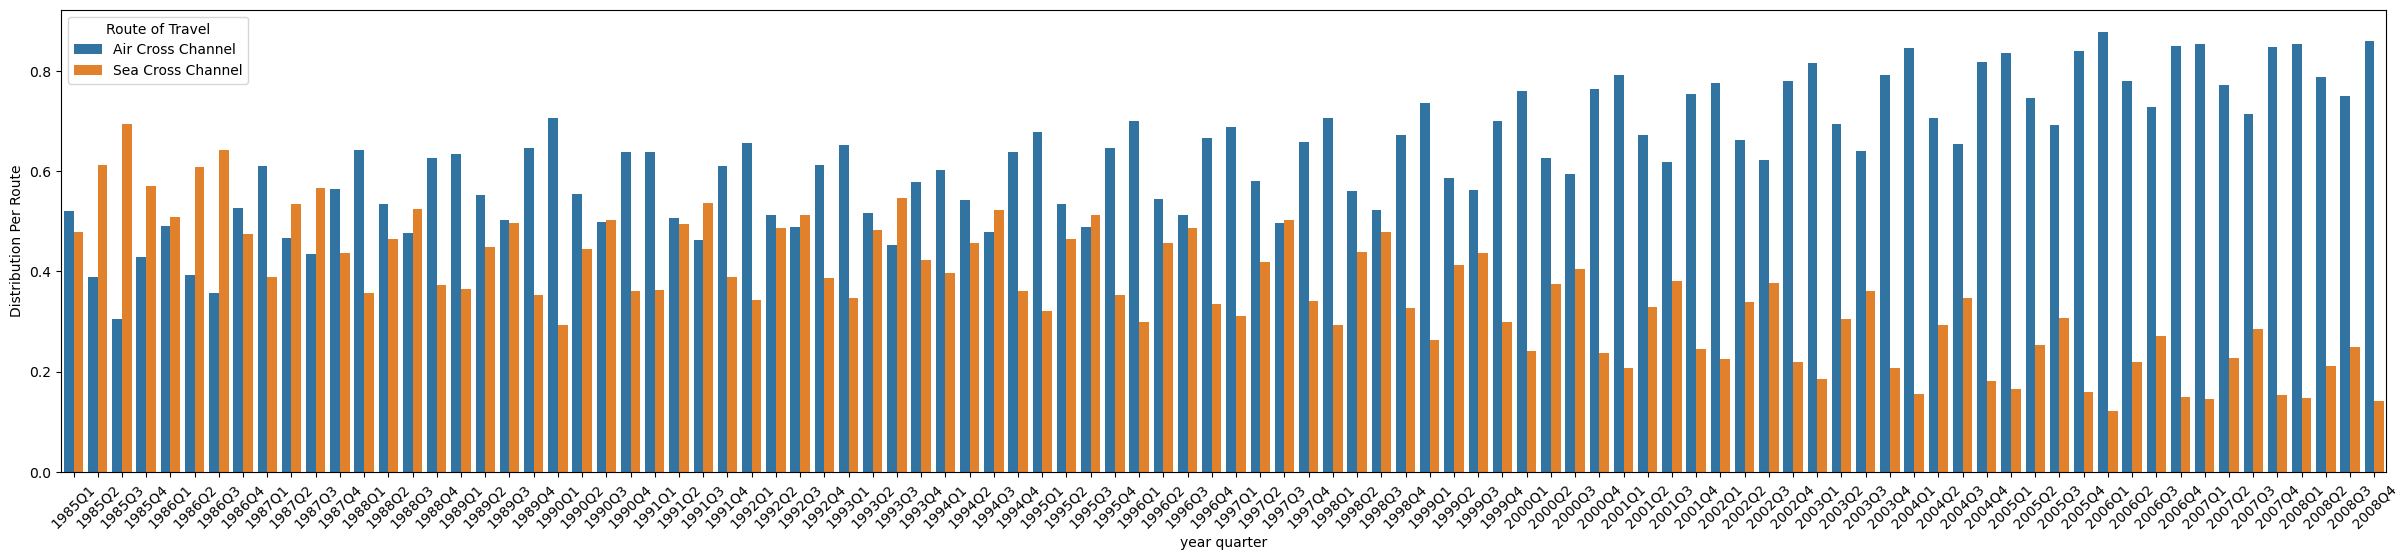

In [343]:
fig, ax3 = plt.subplots(figsize=(30, 6))
sns.barplot(x="year quarter", y="Distribution Per Route", hue="Route of Travel", data=freqs, ax=ax3)
plt.xticks(rotation=45)


In [344]:
# import matplotlib.pyplot as plt

# # Calculate the total Travellers x(1,000) for Combined Air and Sea Cross channel per quarter
# combined_cross_channel['Travellers x(1,000)'] = combined_cross_channel.groupby(['Year', 'Quarter', 'Direction'])['Travellers x(1,000)'].transform('sum')

# # Calculate the percentages for Air Cross Channel and Sea Cross Channel
# Air_Cross_Channel['Percentage'] = (Air_Cross_Channel['Travellers x(1,000)'] / combined_cross_channel['Travellers x(1,000)']) * 100
# Sea_Cross_Channel['Percentage'] = (Sea_Cross_Channel['Travellers x(1,000)'] / combined_cross_channel['Travellers x(1,000)']) * 100

# # Create a new dataframe for the percentages
# percentage_df = pd.concat([Air_Cross_Channel[['Year', 'Quarter', 'Percentage']], Sea_Cross_Channel[['Year', 'Quarter', 'Percentage']]])

# # Plot the data on a barplot
# barplot = sns.barplot(x='Year', y='Percentage', hue='Quarter', data=percentage_df)
# plt.title('Percentage of Travellers x(1,000) for Air Cross Channel and Sea Cross Channel')
# plt.xlabel('Year')
# plt.ylabel('Percentage')
# plt.show()
# combined_cross_channel['Travellers x(1,000)'] = combined_cross_channel.groupby(['Year', 'Quarter'])['Travellers x(1,000)'].transform('sum')

# # Calculate the percentages for Air Cross Channel and Sea Cross Channel
# Air_Cross_Channel['Percentage'] = (Air_Cross_Channel['Travellers x(1,000)'] / combined_cross_channel['Travellers x(1,000)']) * 100
# Sea_Cross_Channel['Percentage'] = (Sea_Cross_Channel['Travellers x(1,000)'] / combined_cross_channel['Travellers x(1,000)']) * 100

# # Print the updated dataframes
# print("Air Cross Channel:")
# print(Air_Cross_Channel[['Year', 'Quarter', 'Percentage']])
# print("\nSea Cross Channel:")
# print(Sea_Cross_Channel[['Year', 'Quarter', 'Percentage']])
# barplot = sns.barplot(x='Year', y='Distribution', data=Distribution_df, hue='Direction')


In [345]:
# Calculate the sum for all Routes of Travel per **year - quarter - direction**
def calculate_frequencies(df):
    print(df.shape)

    sums = df.groupby(['Year', 'Quarter', 'Direction'], as_index=False).sum()
    sums.rename(columns={"Travellers x(1,000)": "Total Num"}, inplace=True)

    # Calculate the number of unique routes, because this is how many times we need to repeat each sum for the division operation
    repeats = df['Route of Travel'].nunique()
    # Extract the total numbers per **year - quarter - direction** and repeat them 3 times, because we have 3 routes
    mask = sums.loc[sums.index.repeat(repeats)].reset_index(drop=True)['Total Num']
    print(mask.shape) # I am making sure the shape of the mask matches the shape of the dataframe we will apply this to

    mask.head()

    # We have to prodive 'ignore_index=True', because otherwise the division by the totals_mask will produce NaN values, as indexes are misaligned
    df.sort_values(by=['Year', 'Quarter', 'Direction', 'Route of Travel'], inplace=True, ignore_index=True)

    #concatenated_route_quarter_tourism['Distribution']
    df['Distribution Per Route'] = df['Travellers x(1,000)'] / mask
    return df

### Merge Air and Sea Cross channel values into combined Cross Channel values

In [346]:
def merge_air_and_sea(df, common_cols):
    # Select cross channel travel by both sea and air for each quarter and year from the dataset
    cross_channel_df = df[df.isin(['Air Cross Channel', 'Sea Cross Channel'])['Route of Travel']==True]
    #pd.set_option('display.max_rows', cross_channel_df.shape[0]+1)
    cross_channel_df.shape
    
    # Combine Air and Sea cross channel travel into Cross channel travel dataframe
    combined_cross_channel = cross_channel_df.groupby(common_cols, as_index=False).sum()
    combined_cross_channel['Route of Travel'] = 'Cross Channel'
    combined_cross_channel.shape

    # Remove Air and Sea Cross Channel travel from original dataset
    df = df.drop(df[df.isin(['Air Cross Channel', 'Sea Cross Channel'])['Route of Travel']==True].index)
    # Concatenate original dataset with new Cross Channel travel dataset
    df = pd.concat([df, combined_cross_channel], axis=0, ignore_index=True)
    #pd.set_option('display.max_rows', df.shape[0]+1)
    # df
    # Change order of routes to "All Routes", "Cross Channel", "Continental Europe", and "Transatlantic" to be consistent with the original dataset.
    concatenated_df = pd.concat([df[df['Route of Travel'] == 'All Routes'],
                                df[df['Route of Travel'] == 'Cross Channel'],
                                df[df['Route of Travel'] == 'Continental Europe'],
                                df[df['Route of Travel'] == 'Transatlantic']])

    # Reset the index of the concatenated dataframe
    concatenated_df.reset_index(drop=True, inplace=True)
    return concatenated_df

In [347]:
concatenated_route_quarter_tourism = merge_air_and_sea(route_quarter_tourism, ['Year', 'Quarter', 'Direction'])
concatenated_route_quarter_tourism['Route of Travel'].value_counts()

Route of Travel
All Routes            192
Cross Channel         192
Continental Europe    192
Transatlantic         192
Name: count, dtype: int64

In [348]:
# Display edited dataset rows and columns after cleaning. (960 rows, 5 routes = (960/5)*4 = 768 rows) 
concatenated_route_quarter_tourism.shape
concatenated_route_quarter_tourism.head()
concatenated_route_quarter_tourism.tail()

(768, 5)

,Route of Travel,Year,Quarter,Direction,"Travellers x(1,000)"
0,All Routes,1985,1,Visitors to Ireland,254
1,All Routes,1985,1,Visits Abroad by Irish Residents,186
2,All Routes,1985,2,Visitors to Ireland,495
3,All Routes,1985,2,Visits Abroad by Irish Residents,336
4,All Routes,1985,3,Visitors to Ireland,840


,Route of Travel,Year,Quarter,Direction,"Travellers x(1,000)"
763,Transatlantic,2008,2,Visits Abroad by Irish Residents,115
764,Transatlantic,2008,3,Visitors to Ireland,218
765,Transatlantic,2008,3,Visits Abroad by Irish Residents,142
766,Transatlantic,2008,4,Visitors to Ireland,101
767,Transatlantic,2008,4,Visits Abroad by Irish Residents,152


In [349]:
concatenated_route_quarter_tourism = concatenated_route_quarter_tourism.drop(concatenated_route_quarter_tourism[concatenated_route_quarter_tourism.isin(['All Routes'])['Route of Travel']==True].index)

concatenated_route_quarter_tourism

,Route of Travel,Year,Quarter,Direction,"Travellers x(1,000)"
192,Cross Channel,1985,1,Visitors to Ireland,211
193,Cross Channel,1985,1,Visits Abroad by Irish Residents,140
194,Cross Channel,1985,2,Visitors to Ireland,366
195,Cross Channel,1985,2,Visits Abroad by Irish Residents,221
196,Cross Channel,1985,3,Visitors to Ireland,608
...,...,...,...,...,...
763,Transatlantic,2008,2,Visits Abroad by Irish Residents,115
764,Transatlantic,2008,3,Visitors to Ireland,218
765,Transatlantic,2008,3,Visits Abroad by Irish Residents,142
766,Transatlantic,2008,4,Visitors to Ireland,101


In [350]:

concateneated_freqs = calculate_frequencies(concatenated_route_quarter_tourism)
concateneated_freqs


(576, 5)
(576,)


,Route of Travel,Year,Quarter,Direction,"Travellers x(1,000)",Distribution Per Route
0,Continental Europe,1985,1,Visitors to Ireland,28,0.110236
1,Cross Channel,1985,1,Visitors to Ireland,211,0.830709
2,Transatlantic,1985,1,Visitors to Ireland,15,0.059055
3,Continental Europe,1985,1,Visits Abroad by Irish Residents,41,0.220430
4,Cross Channel,1985,1,Visits Abroad by Irish Residents,140,0.752688
...,...,...,...,...,...,...
571,Cross Channel,2008,4,Visitors to Ireland,981,0.589189
572,Transatlantic,2008,4,Visitors to Ireland,101,0.060661
573,Continental Europe,2008,4,Visits Abroad by Irish Residents,806,0.492966
574,Cross Channel,2008,4,Visits Abroad by Irish Residents,677,0.414067


<Axes: xlabel='Year', ylabel='Distribution Per Route'>

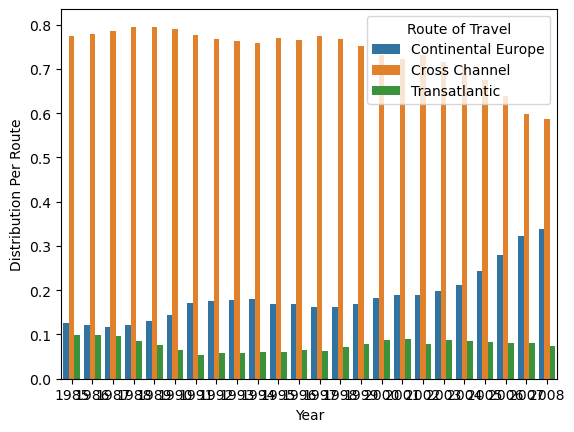

In [351]:
to_ireland = concatenated_route_quarter_tourism[concatenated_route_quarter_tourism['Direction'] == 'Visitors to Ireland']
sns.barplot(x='Year', y='Distribution Per Route', data=to_ireland, hue='Route of Travel', ci=None)

## Expenditures Dataset: Exploration and Cleaning
#### Explore expend_quarter dataset
#### Dataset describes travel to and from Ireland by all routes between the years of 1985 and 2008, Quarterly, with Expenditure.

In [352]:
# Read csv file into pandas dataframe
# url = https://data.gov.ie/dataset/tmq03-expenditure-of-visitors-to-and-from-ireland/resource/231eb892-f7cf-4a1a-93d2-25754c99e3b1
# TMQ03-Expenditure-of-Visitors-to-and-from-Ireland dataset contains 8 columns and 192 rows
# (24 years in Quarters = 96 rows), 96 rows by 2 Direction = 192 rows
# Columns: C02196V02652, State, TLIST(Q1), Quarter, STATISTIC, Statistic Label, UNIT, VALUE
# Columns 1 and 2 do not contain useful information
expend_quarter = pd.read_csv("TMQ03-Expenditure-of-Visitors-to-and-from-Ireland.csv")

expend_quarter.shape

(192, 8)

### Display column names in Dataset 2

In [353]:
print(expend_quarter.columns)

Index(['C02196V02652', 'State', 'TLIST(Q1)', 'Quarter', 'STATISTIC',
       'Statistic Label', 'UNIT', 'VALUE'],
      dtype='object')


In [354]:
expend_quarter['State'].value_counts()
expend_quarter['Statistic Label'].value_counts()
expend_quarter['C02196V02652'].value_counts()
expend_quarter['UNIT'].value_counts()
expend_quarter['VALUE'].value_counts(bins=10)

State
State    192
Name: count, dtype: int64

Statistic Label
Expenditure of Visitors to Ireland (excluding International fares)       96
Expenditure of Irish Residents Abroad (including International fares)    96
Name: count, dtype: int64

C02196V02652
-    192
Name: count, dtype: int64

UNIT
Euro Million    192
Name: count, dtype: int64

(66.702, 298.7]     55
(298.7, 528.4]      40
(528.4, 758.1]      30
(758.1, 987.8]      24
(987.8, 1217.5]     18
(1447.2, 1676.9]    10
(1217.5, 1447.2]     8
(1676.9, 1906.6]     5
(1906.6, 2136.3]     1
(2136.3, 2366.0]     1
Name: count, dtype: int64

In [355]:
expend_quarter.head(10)

,C02196V02652,State,TLIST(Q1),Quarter,STATISTIC,Statistic Label,UNIT,VALUE
0,-,State,19851,1985Q1,TMQ03C1,Expenditure of Visitors to Ireland (excluding ...,Euro Million,107
1,-,State,19851,1985Q1,TMQ03C2,Expenditure of Irish Residents Abroad (includi...,Euro Million,69
2,-,State,19852,1985Q2,TMQ03C1,Expenditure of Visitors to Ireland (excluding ...,Euro Million,217
3,-,State,19852,1985Q2,TMQ03C2,Expenditure of Irish Residents Abroad (includi...,Euro Million,133
4,-,State,19853,1985Q3,TMQ03C1,Expenditure of Visitors to Ireland (excluding ...,Euro Million,410
5,-,State,19853,1985Q3,TMQ03C2,Expenditure of Irish Residents Abroad (includi...,Euro Million,207
6,-,State,19854,1985Q4,TMQ03C1,Expenditure of Visitors to Ireland (excluding ...,Euro Million,136
7,-,State,19854,1985Q4,TMQ03C2,Expenditure of Irish Residents Abroad (includi...,Euro Million,102
8,-,State,19861,1986Q1,TMQ03C1,Expenditure of Visitors to Ireland (excluding ...,Euro Million,109
9,-,State,19861,1986Q1,TMQ03C2,Expenditure of Irish Residents Abroad (includi...,Euro Million,95


## Edit Dataframe 2 - Data Cleaning 
### Remove, Rename and Transform columns

In [356]:
# Remove 'UNIT' column as 'VALUE' column heading will be amended to reflect units. 
# Remove 'ROUTE' column as 'Route of Travel' contains the same information in human readable language.
# Remove 'STATISTIC' column as this data is contained within 'Quarter' and 'Statistic Label' columns in human readable language.
expend_quarter_tourism = expend_quarter.drop(columns=['UNIT', 'State', 'C02196V02652', 'STATISTIC'])

# Rename 'TLIST(Q1)' column to Year
expend_quarter_tourism.rename(columns={"TLIST(Q1)": "Year"}, inplace=True)

# Last character in 'Year' column refers to quarter (1-4) 
# Remove last character from by dividing by 10 and saving as integer to remove non-whole numbers. e.g. 19854 -> 1985.4 = 1985
expend_quarter_tourism["Year"] = expend_quarter_tourism["Year"].transform(lambda x: x / 10).astype(int)

# The'Quarter' column contains the year and Q before the number designating the quarter. e.g. 1985Q4
# Transform 'Quarter' column, reassigning last character of each entry as integer reflecting the quarter. e.g. 1985Q4 = 4
expend_quarter_tourism["Quarter"] = expend_quarter_tourism["Quarter"].transform(lambda x: str(x)[-1]).astype(int)

# Rename 'Statistic Label' column for Direction
expend_quarter_tourism.rename(columns={"Statistic Label": "Direction"}, inplace=True)

# Rename Column for Travellers x 1,000
expend_quarter_tourism.rename(columns={"VALUE": "Expenditure x(€1,000,000)"}, inplace=True)

expend_quarter_tourism.shape

(192, 4)

In [357]:
# A better way of renaming column values to enable concatenation of the two datasets
direction_mapping = {'Expenditure of Visitors to Ireland (excluding International fares)': 'Visitors to Ireland',
                     'Expenditure of Irish Residents Abroad (including International fares)': 'Visits Abroad by Irish Residents'}

expend_quarter_tourism["Direction"]=expend_quarter_tourism['Direction'].apply(lambda x: direction_mapping[x])

### Display column names in edited dataframe 2

In [358]:
print(expend_quarter_tourism.columns)

Index(['Year', 'Quarter', 'Direction', 'Expenditure x(€1,000,000)'], dtype='object')


In [359]:
expend_quarter_tourism.head()

,Year,Quarter,Direction,"Expenditure x(€1,000,000)"
0,1985,1,Visitors to Ireland,107
1,1985,1,Visits Abroad by Irish Residents,69
2,1985,2,Visitors to Ireland,217
3,1985,2,Visits Abroad by Irish Residents,133
4,1985,3,Visitors to Ireland,410


In [360]:
expend_quarter_tourism.shape

(192, 4)

## Dataset 3_duration_of_stay - Exploration and Cleaning
#### Explore duration_of_stay dataset
#### Dataset describes travel to and from Ireland by all routes between the years of 1976 and 2008, Yearly, with Lenght of Stay.

In [361]:
# Read csv file into pandas dataframe 
# url = https://data.gov.ie/dataset/tma04-visits-to-and-from-ireland/resource/47481033-39c0-4eda-b02e-d0dba591ab31
duration_of_stay = pd.read_csv("TMA04-Visits-to-and-from-Ireland.csv")
duration_of_stay.shape

(660, 8)

In [362]:
# TMA04-Visits-to-and-from-Ireland dataset contains 8 columns and 660 rows
# (33 years in Years=33 rows),33 rows by 2 Direction=66 rows,66 rows by 5 regions=330 rows by 2(lenght of stay and number) = 660 rows
# Columns: ROUTE, Route of Travel, TLIST(A1), Year, STATISTIC, Statistic Label, UNIT, VALUE

print(duration_of_stay.columns)
duration_of_stay.head(10)

Index(['ROUTE', 'Route of Travel', 'TLIST(A1)', 'Year', 'STATISTIC',
       'Statistic Label', 'UNIT', 'VALUE'],
      dtype='object')


,ROUTE,Route of Travel,TLIST(A1),Year,STATISTIC,Statistic Label,UNIT,VALUE
0,0,All Routes,1976,1976,TMA04C1,Visitors to Ireland,Thousand,1312.0
1,0,All Routes,1976,1976,TMA04C2,Average Length of Stay by Visitors to Ireland,Nights,12.0
2,0,All Routes,1976,1976,TMA04C3,Visits Abroad by Irish Residents,Thousand,886.0
3,0,All Routes,1976,1976,TMA04C4,Average Length of Stay Abroad by Irish Residents,Nights,11.2
4,0,All Routes,1977,1977,TMA04C1,Visitors to Ireland,Thousand,1473.0
5,0,All Routes,1977,1977,TMA04C2,Average Length of Stay by Visitors to Ireland,Nights,11.3
6,0,All Routes,1977,1977,TMA04C3,Visits Abroad by Irish Residents,Thousand,969.0
7,0,All Routes,1977,1977,TMA04C4,Average Length of Stay Abroad by Irish Residents,Nights,10.6
8,0,All Routes,1978,1978,TMA04C1,Visitors to Ireland,Thousand,1673.0
9,0,All Routes,1978,1978,TMA04C2,Average Length of Stay by Visitors to Ireland,Nights,10.7


In [363]:
# Remove rows for years 1976 to 1985, without matching data in other datasets, Edited to include 1985-2008
# (24 years in Years = 24 rows), 24 rows by 2 Direction = 48 rows, 48 rows by 5 regions = 240 rows by 2(lenght of stay and number) = 480 rows
# Columns: ROUTE, Route of Travel, TLIST(A1), Year, STATISTIC, Statistic Label, UNIT, VALUE
duration_of_stay = duration_of_stay[duration_of_stay['Year'] > 1984]
duration_of_stay.shape

(480, 8)

In [364]:
duration_of_stay['UNIT'].value_counts()

UNIT
Thousand    240
Nights      240
Name: count, dtype: int64

In [365]:
# Remove 'UNIT' column as 'VALUE' column heading will be amended to reflect units. 
# Remove 'ROUTE' column as 'Route of Travel' contains the same information in human readable language.
# Remove 'STATISTIC' column as this data is contained within 'Quarter' and 'Statistic Label' columns in human readable language.
duration_of_stay = duration_of_stay.drop(columns=['UNIT', 'ROUTE', 'STATISTIC', 'TLIST(A1)'])

# Rename 'TLIST(Q1)' column to Year
duration_of_stay.rename(columns={"TLIST(A1)": "Year"}, inplace=True)

# Rename 'Statistic Label' column for Direction
duration_of_stay.rename(columns={"Statistic Label": "Direction"}, inplace=True)

duration_of_stay.shape

(480, 4)

In [366]:
num_visitors = duration_of_stay[(duration_of_stay['Direction'] == 'Visitors to Ireland') | (duration_of_stay['Direction'] == 'Visits Abroad by Irish Residents')]
duration_of_stay_nights = duration_of_stay[(duration_of_stay['Direction'] == 'Average Length of Stay Abroad by Irish Residents') | (duration_of_stay['Direction'] == 'Average Length of Stay by Visitors to Ireland')]

num_visitors.rename(columns={"VALUE": "Num Visitors (x 1,000)"}, inplace=True)
duration_of_stay_nights.rename(columns={"VALUE": "Length Stay (Nights)"}, inplace=True)

num_visitors.shape
duration_of_stay_nights.shape


(240, 4)

(240, 4)

In [367]:
direction_mapping = {'Average Length of Stay by Visitors to Ireland': 'Visitors to Ireland',
                     'Average Length of Stay Abroad by Irish Residents': 'Visits Abroad by Irish Residents'}

duration_of_stay_nights["Direction"] = duration_of_stay_nights['Direction'].apply(lambda x: direction_mapping[x])

In [368]:
duration_and_num = num_visitors.merge(duration_of_stay_nights, on=['Year', 'Direction', 'Route of Travel'])
duration_and_num

,Route of Travel,Year,Direction,"Num Visitors (x 1,000)",Length Stay (Nights)
0,All Routes,1985,Visitors to Ireland,1912.0,9.9
1,All Routes,1985,Visits Abroad by Irish Residents,1258.0,9.5
2,All Routes,1986,Visitors to Ireland,1813.0,9.9
3,All Routes,1986,Visits Abroad by Irish Residents,1375.0,10.7
4,All Routes,1987,Visitors to Ireland,2039.0,9.4
...,...,...,...,...,...
235,Transatlantic,2006,Visits Abroad by Irish Residents,387.0,10.9
236,Transatlantic,2007,Visitors to Ireland,669.0,9.5
237,Transatlantic,2007,Visits Abroad by Irish Residents,441.0,10.2
238,Transatlantic,2008,Visitors to Ireland,603.0,10.2


In [369]:
concatenated_duration_and_num = merge_air_and_sea(duration_and_num, ['Year', 'Direction'])
concatenated_duration_and_num.shape

(192, 5)

In [370]:
# duration_of_stay['ROUTE'].value_counts()
# duration_of_stay['Route of Travel'].value_counts()
# duration_of_stay['Year'].value_counts()
# duration_of_stay['STATISTIC'].value_counts()
# duration_of_stay['Statistic Label'].value_counts()
# duration_of_stay['UNIT'].value_counts()
# duration_of_stay['VALUE'].value_counts(bins=10)

## Merging Cleaned Dataframes 1 & 2

In [371]:
merged_route_quarter_2['Route of Travel'].value_counts()
merged_route_quarter_2['Year'].value_counts()
merged_route_quarter_2['Quarter'].value_counts()
merged_route_quarter_2['Direction'].value_counts()


NameError: name 'merged_route_quarter_2' is not defined

In [ ]:
# Merging dataframe 1 and 2 together on common column values for 'All Routes' values in Route of Travel column 
merged_route_quarter_2 = pd.merge(concatenated_route_quarter_tourism[concatenated_route_quarter_tourism['Route of Travel'] == 'All Routes'], expend_quarter_tourism, on=['Year', 'Quarter', 'Direction'])

print(merged_route_quarter_2.columns)
merged_route_quarter_2.shape

## Dataset 4_reason - Exploration and Cleaning
#### Explore reason dataset
#### Dataset describes travel to and from Ireland by all routes between the years of 1976 and 2008, yearly, with lenght of stay, reason for travel and expenditure .

In [ ]:
# Read csv file into pandas dataframe 
# url = https://data.gov.ie/dataset/tma05-visits-to-and-from-ireland/resource/3fe9ec9d-c16f-47dc-92e3-6749c6361d7c

reason = pd.read_csv("TMA05-Visits-to-and-from-Ireland.csv")
reason.shape

(792, 8)

In [ ]:
# TMA05-Visits-to-and-from-Ireland dataset contains 8 columns and 792 rows
# (33 years in Years = 33 rows), 33 rows by 2 Direction = 66 rows, 66 rows by 4 reasons for travel = 264 rows 
# 264 rows by 3 Features (lenght of stay, expense, # of visitors) = 792 rows
# Columns: C02118V02559, Reason for Journey, TLIST(A1), Year, STATISTIC, Statistic Label, UNIT, VALUE

print(reason.columns)
reason.head(10)

Index(['C02118V02559', 'Reason for Journey', 'TLIST(A1)', 'Year', 'STATISTIC',
       'Statistic Label', 'UNIT', 'VALUE'],
      dtype='object')


,C02118V02559,Reason for Journey,TLIST(A1),Year,STATISTIC,Statistic Label,UNIT,VALUE
0,1,Holiday/leisure/recreation,1976,1976,TMA05C1,Expenditure by Vistors to Ireland,Euro Million,69.0
1,1,Holiday/leisure/recreation,1976,1976,TMA05C2,Visitors to Ireland,Thousand,553.0
2,1,Holiday/leisure/recreation,1976,1976,TMA05C3,Average Length of Stay by Visitors to Ireland,Nights,NaN
3,1,Holiday/leisure/recreation,1976,1976,TMA05C4,Expenditure by Irish Residents Abroad,Euro Million,81.0
4,1,Holiday/leisure/recreation,1976,1976,TMA05C5,Visits Abroad by Irish Residents,Thousand,428.0
5,1,Holiday/leisure/recreation,1976,1976,TMA05C6,Average Length of Stay Abroad by Irish Residents,Nights,NaN
6,1,Holiday/leisure/recreation,1977,1977,TMA05C1,Expenditure by Vistors to Ireland,Euro Million,98.0
7,1,Holiday/leisure/recreation,1977,1977,TMA05C2,Visitors to Ireland,Thousand,665.0
8,1,Holiday/leisure/recreation,1977,1977,TMA05C3,Average Length of Stay by Visitors to Ireland,Nights,NaN
9,1,Holiday/leisure/recreation,1977,1977,TMA05C4,Expenditure by Irish Residents Abroad,Euro Million,94.0


# STOPPED HERE!!!

In [ ]:
concatenated_df.shape

## Explore Imported Dataset

#### Dataset describes travel to and from Ireland by routes between the years of 1985 and 2008.

In [ ]:
# Prints out the first few rows

concatenated_df.tail(144)
columns_without_values = concatenated_df.columns[concatenated_df.isnull().all()]
columns_without_values


In [ ]:

missing_values = concatenated_df.isnull().sum()
print(missing_values)


In [ ]:
# Dataframe is composed of 8 Columns and 960 Rows
concatenated_df.shape

In [ ]:
df.describe()

#### Dataset contains categorical and quantitative variables 
#### Categorical = 
#### Quantitative = 

In [ ]:
concatenated_df.dtypes

## Edit Dataframe - Data Cleaning

### Remove, Rename and Transform columns  

In [ ]:
# Remove 'UNIT' column as 'VALUE' column heading will be amended to reflect units. 
# Remove 'ROUTE' column as 'Route of Travel' contains the same information in human readable language.
# Remove 'STATISTIC' column as this data is contained within 'Quarter' and 'Statistic Label' columns in human readable language.
tourism_df = route_quarter.drop(columns=['UNIT', 'ROUTE', 'STATISTIC'])

# Rename 'TLIST(Q1)' column to Year
tourism_df.rename(columns={"TLIST(Q1)": "Year"}, inplace=True)

# Last character in 'Year' column refers to quarter (1-4) 
# Remove last character from by dividing by 10 and saving as integer to remove non-whole numbers. e.g. 19854 -> 1985.4 = 1985
tourism_df["Year"] = tourism_df["Year"].transform(lambda x: x / 10).astype(int)

# The'Quarter' column contains the year and Q before the number designating the quarter. e.g. 1985Q4
# Transform 'Quarter' column, reassigning last character of each entry as integer reflecting the quarter. e.g. 1985Q4 = 4
tourism_df["Quarter"] = tourism_df["Quarter"].transform(lambda x: str(x)[-1]).astype(int)

# Rename 'Statistic Label' column for Direction
tourism_df.rename(columns={"Statistic Label": "Direction"}, inplace=True)

# Rename Column for Travellers x 1,000
tourism_df.rename(columns={"VALUE": "Travellers (x 1,000)"}, inplace=True)
#pd.set_option('display.max_rows', tourism_df.shape[0]+1)
tourism_df

## Explore Edited Dataframe

In [ ]:
# Select cross channel travel by both sea and air for each quarter and year
cross_channel_df = tourism_df[tourism_df.isin(['Air Cross Channel', 'Sea Cross Channel'])['Route of Travel']==True]
#pd.set_option('display.max_rows', 10)
cross_channel_df

In [ ]:
# Combine Air and Sea cross channel travel into Cross channel travel dataframe
combined_cross_channel = cross_channel_df.groupby(['Year', 'Quarter', 'Direction'], as_index=False).sum()
combined_cross_channel['Route of Travel'] = 'Cross Channel'
combined_cross_channel

In [ ]:
# Drop all rows containing cross channel travel by air or sea
tourism_df = tourism_df.drop(tourism_df[tourism_df.isin(['Air Cross Channel', 'Sea Cross Channel'])['Route of Travel']==True].index)

In [ ]:
# Concatenate the datasets with the specified order of "All Routes", "Cross Channel", "Continental Europe", and "Transatlantic" to be consistent
# with the original dataset.
concatenated_df = pd.concat([tourism_df[tourism_df['Route of Travel'] == 'All Routes'],
                            tourism_df[tourism_df['Route of Travel'] == 'Cross Channel'],
                            tourism_df[tourism_df['Route of Travel'] == 'Continental Europe'],
                            tourism_df[tourism_df['Route of Travel'] == 'Transatlantic']])

# Reset the index of the concatenated dataframe
concatenated_df.reset_index(drop=True, inplace=True)

# Display the concatenated dataframe
concatenated_df


In [ ]:
# Assess how many Series and Rows in tidied dataframe
tourism_df.shape

In [ ]:
tourism_df.dtypes

In [ ]:
tourism_df.describe()

In [ ]:
# Remove rows without matching data in other datasets
duration_of_stay = duration_of_stay[duration_of_stay['Year'] > 1984]
reason = reason[reason['Year'] > 1984]
# Concatenate datasets horizontally
concatenated_df = pd.concat([route_quarter, expend_quarter, duration_of_stay, reason], axis=1)
concatenated_df.head(50)

## Create Seperate Dataframe of Inbound Travel to Ireland

In [ ]:
# Create new seperate dataframes for inbound Irish travel
intourism_df = tourism_df[tourism_df['Direction'] == 'Visitors to Ireland']
intourism_df = intourism_df.drop(columns=['Direction'])
#intourism_df = intourism_df.drop(intourism_df[intourism_df['Route of Travel'] == 'All Routes'].index)

In [ ]:
(intourism_df.head(5))

In [ ]:
intourism_df.shape

In [ ]:
intourism_df.describe()

In [ ]:
# 5 categories for Routes of Travel with column 0 = Sum of columns 1-4
intourism_df['Route of Travel'].value_counts() 

In [ ]:
# Create dataframe with values for each quarter of the year summed to give travel into Ireland per year by each route 
in_grouped = intourism_df.groupby(['Year', 'Route of Travel'], as_index=False).sum().drop(columns=['Quarter'])
in_grouped

In [ ]:
# Assess demographics of tourists travelling to Ireland from different regions over time
plt.figure(figsize=(12, 6))

ax = sns.barplot(data=in_grouped, x="Year", y="Travellers (x 1,000)", hue='Route of Travel')
ax.tick_params(axis='x', labelrotation=45)

## Create Seperate Dataframe of Outbound Travel from Ireland

In [ ]:
# Create new seperate dataframes for inbound Irish travel
outtourism_df = tourism_df[tourism_df['Direction'] == 'Visits Abroad by Irish Residents']
outtourism_df = outtourism_df.drop(columns=['Direction'])
#outtourism_df = outtourism_df.drop(outtourism_df[outtourism_df['Route of Travel'] == 'All Routes'].index)
#outtourism_df = outtourism_df.sum(outtourism_df[outtourism_df['Route of Travel'] == 'All Routes'].index)

In [ ]:
(outtourism_df.tail(5))

In [ ]:
outtourism_df.shape

In [ ]:
outtourism_df.describe()

In [ ]:
# 5 categories for Routes of Travel with column 0 = Sum of columns 1-4
outtourism_df['Route of Travel'].value_counts() 

In [ ]:
# Create dataframe with values for each quarter of the year summed to give travel from Ireland per year by each route 
out_grouped = outtourism_df.groupby(['Year', 'Route of Travel'], as_index=False).sum().drop(columns=['Quarter'])
out_grouped

In [ ]:
# Assess demographics of tourists travelling from Ireland to different regions over time
plt.figure(figsize=(12, 6))

ax = sns.barplot(data=out_grouped, x="Year", y="Travellers (x 1,000)", hue='Route of Travel')
ax.tick_params(axis='x', labelrotation=45)

## Travel to Ireland by Quarter
Q1: January – March, Q2: April – June, Q3: July – September, Q4: October – December

In [ ]:
# Assess demographics of tourists travelling to Ireland from different regions per Quarter
plt.figure(figsize=(12, 6))

ax = sns.barplot(data=intourism_df, x="Route of Travel", y="Travellers (x 1,000)", hue='Quarter')
ax.tick_params(axis='x', labelrotation=45)

In [ ]:
# Assess demographics of tourists travelling to Ireland from different regions per Quarter
plt.figure(figsize=(12, 6))

ax = sns.barplot(data=intourism_df, x="Quarter", y="Travellers (x 1,000)", hue='Route of Travel')
ax.tick_params(axis='x', labelrotation=45)

## Travel from Ireland by Quarter

In [ ]:
# Assess demographics of tourists travelling from Ireland to different regions per Quarter
plt.figure(figsize=(12, 6))

ax = sns.barplot(data=outtourism_df, x="Route of Travel", y="Travellers (x 1,000)", hue='Quarter')
ax.tick_params(axis='x', labelrotation=45)

In [ ]:
# Assess demographics of tourists travelling from Ireland to different regions per Quarter
plt.figure(figsize=(12, 6))

ax = sns.barplot(data=outtourism_df, x="Quarter", y="Travellers (x 1,000)", hue='Route of Travel')
ax.tick_params(axis='x', labelrotation=45)

## Lineplot of Tourism out of Ireland

In [ ]:
# Assess demographics of tourists travelling from Ireland to different regions per Quarter

plt.figure(figsize=(12, 6))

ax = sns.lineplot(data=outtourism_df, x="Year", y="Travellers (x 1,000)", hue='Route of Travel')
ax.tick_params(axis='x', labelrotation=45)

In [ ]:
# Assess demographics of tourists travelling from Ireland to different regions per Quarter
plt.figure(figsize=(12, 6))

ax = sns.lineplot(data=out_grouped, x="Year", y="Travellers (x 1,000)", hue='Route of Travel')
ax.tick_params(axis='x', labelrotation=45)

## Lineplot of Tourism into Ireland

In [ ]:
# Assess demographics of tourists travelling from Ireland to different regions per Quarter
plt.figure(figsize=(12, 6))

ax = sns.lineplot(data=in_grouped, x="Year", y="Travellers (x 1,000)", hue='Route of Travel')
ax.tick_params(axis='x', labelrotation=45)

In [ ]:
# Assess demographics of tourists travelling from Ireland to different regions per Quarter
plt.figure(figsize=(12, 6))

ax = sns.lineplot(data=intourism_df, x="Year", y="Travellers (x 1,000)", hue='Route of Travel')
ax.tick_params(axis='x', labelrotation=45)